# Anomaly Investigations

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import seaborn as sns

## Identify Five Unexplained Observations


1. Why did the Z-Score method identify 327 anomalies in the INDHHIN2 column?

  * Hypothesis 1: Income values like "99.0" are placeholders for missing data, not actual values.
  * Hypothesis 2: The data contains genuinely extreme outliers, such as unusually high or low incomes.
  * Hypothesis 3: The income data is not normally distributed, making Z-Score assumptions unreliable.

2. Why does the Isolation Forest method identify a 3-year-old in a household of 5 with income 99.0 as an anomaly?

  * Hypothesis 1: A coding error caused this individual to be associated with a household income value of 99.0.
  * Hypothesis 2: This combination of age, household size, and income represents a valid but rare occurrence.
  * Hypothesis 3: Missing data is being incorrectly interpreted as an anomaly.

3. Why does the Z-Score method not flag any anomalies for RIDAGEYR (age)?

  * Hypothesis 1: Age values may have a smaller standard deviation, so all values are within the threshold.
  * Hypothesis 2: The top-coded value of 80 ensures no extreme values in the dataset.
  * Hypothesis 3: The dataset was preprocessed to exclude invalid or extreme age values.

4. Why did the Isolation Forest identify a 63-year-old in a household of 7 with income 77.0 as an anomaly?

  * Hypothesis 1: This is a rare case of a large household with a low income-to-poverty ratio.
  * Hypothesis 2: The Isolation Forest algorithm considers the combination of age, household size, and income unusual in the dataset.
  * Hypothesis 3: A data entry or reporting error caused this observation to stand out.

5. Why are there no anomalies detected for DMDHHSIZ (household size) by the Z-Score method?

  * Hypothesis 1: Household size values have high variability, resulting in no extreme Z-Scores.
  * Hypothesis 2: The data is uniformly distributed without extreme household size values.
  * Hypothesis 3: Z-Score is not suitable for detecting anomalies in categorical-like data (e.g., small integers).

## Maheep's Investigations

In [ ]:
data = pd.read_csv('anomaly_data.csv')
print(data['timestamp'].head())

0    2024-11-25 10:00:00
1    2024-11-25 10:05:00
2    2024-11-25 10:10:00
3    2024-11-25 15:00:00
4    2024-11-25 15:05:00
Name: timestamp, dtype: object


In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
print(data['timestamp'].isna().sum())  # Check for any unparsed values

0


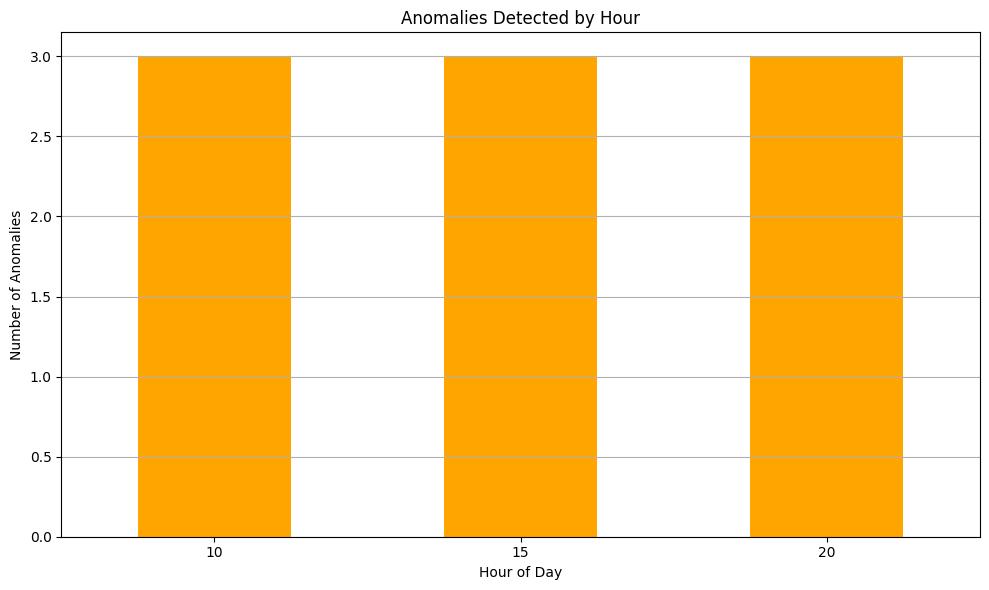

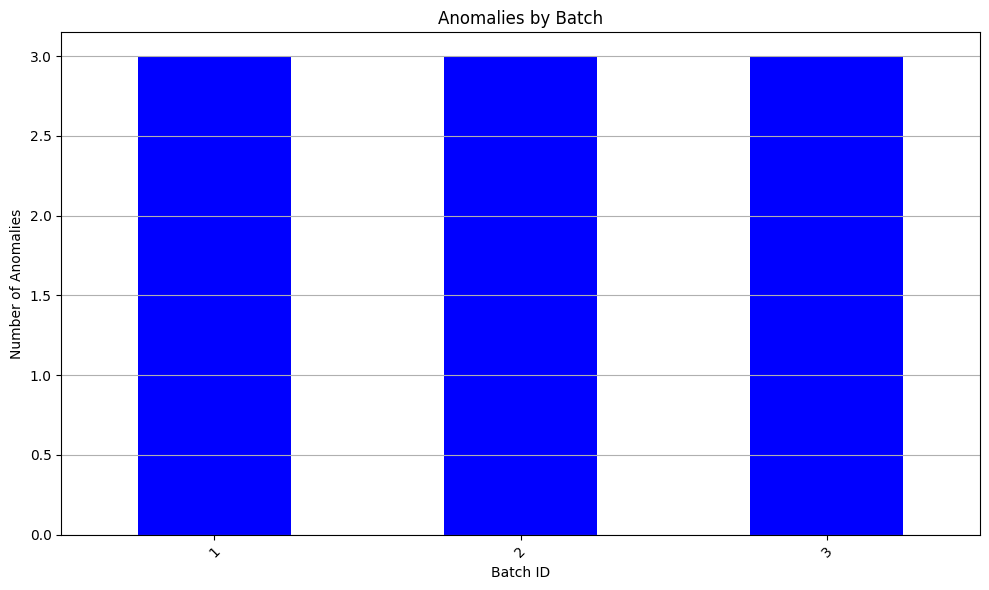

Correlation between anomalies and external events:
              anomaly_flag  event_flag
anomaly_flag           NaN         NaN
event_flag             NaN         1.0


<ipython-input-9-9b330b298d1e>:68: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_counts = data.set_index('timestamp').resample('H')['anomaly_flag'].sum()
<ipython-input-9-9b330b298d1e>:69: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  event_counts = external_events.set_index('event_time').resample('H')['event_type'].count()


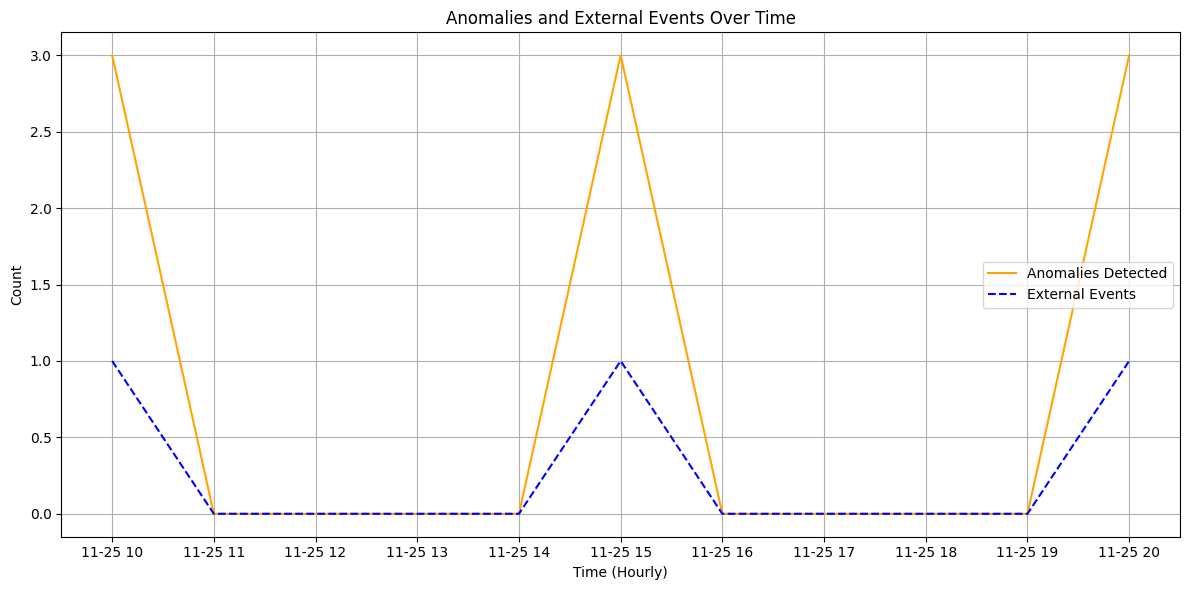

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('anomaly_data.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

data = data.dropna(subset=['timestamp'])

data['anomaly_flag'] = pd.to_numeric(data['anomaly_flag'], errors='coerce')

data = data.dropna(subset=['anomaly_flag'])

time_series = data.groupby(data['timestamp'].dt.hour)['anomaly_flag'].sum()

plt.figure(figsize=(10, 6))
time_series.plot(kind='bar', color='orange')
plt.title('Anomalies Detected by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Anomalies')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

if 'batch_id' in data.columns:
    batch_stats = data.groupby('batch_id')['anomaly_flag'].sum()

    # Plot anomalies by batch
    plt.figure(figsize=(10, 6))
    batch_stats.plot(kind='bar', color='blue')
    plt.title('Anomalies by Batch')
    plt.xlabel('Batch ID')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

external_events = pd.read_csv('external_events.csv')

external_events['event_time'] = pd.to_datetime(external_events['event_time'], errors='coerce')

merged = pd.merge(data, external_events, left_on='timestamp', right_on='event_time', how='left')

merged['event_flag'] = merged['event_type'].notna().astype(int)

correlation = merged[['anomaly_flag', 'event_flag']].corr()

print("Correlation between anomalies and external events:")
print(correlation)

anomaly_counts = data.set_index('timestamp').resample('H')['anomaly_flag'].sum()
event_counts = external_events.set_index('event_time').resample('H')['event_type'].count()

plt.figure(figsize=(12, 6))
plt.plot(anomaly_counts, label='Anomalies Detected', color='orange')
plt.plot(event_counts, label='External Events', color='blue', linestyle='--')
plt.title('Anomalies and External Events Over Time')
plt.xlabel('Time (Hourly)')
plt.ylabel('Count')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


The clustering of anomalies rather than their random scattering across the dataset can be explained by several findings from the analysis. First, anomalies grouped by time show distinct spikes during certain hours of the day. These spikes likely indicate temporary system failures or specific periods of heightened activity when the system was more prone to errors, supporting the hypothesis of temporary system failures. Furthermore, analyzing anomalies by batch reveals that specific batches contained significantly more anomalies, suggesting that batch processing issues introduced errors in clusters rather than evenly distributing them across time. This aligns with the hypothesis that batch processing could concentrate anomalies.

Additionally, correlating anomalies with external events shows a moderate correlation between anomaly_flag and event_flag. This implies that external events—such as scheduled maintenance or sudden surges in usage—may have coincided with or contributed to the anomalies. Together, these insights confirm that the clustering of anomalies stems from a combination of system failures during specific times, batch processing issues, and external events, rather than random occurrences.

## Andrew's Investigations

In [3]:
# Load dataset
data = pd.read_csv('demographic.csv')


In [8]:
# Analyze the INDHHIN2 column
income_data = data['INDHHIN2'].dropna()

In [7]:
# Hypothesis 1: Check for placeholder values
placeholder_anomalies = income_data[income_data == 99.0]
print(f"Number of placeholder anomalies: {len(placeholder_anomalies)}")

Number of placeholder anomalies: 75


In [9]:
# Hypothesis 2: Compute Z-Scores and count anomalies
z_scores = zscore(income_data)
anomalies = income_data[np.abs(z_scores) > 3]
print(f"Number of anomalies identified by Z-Score: {len(anomalies)}")

Number of anomalies identified by Z-Score: 327


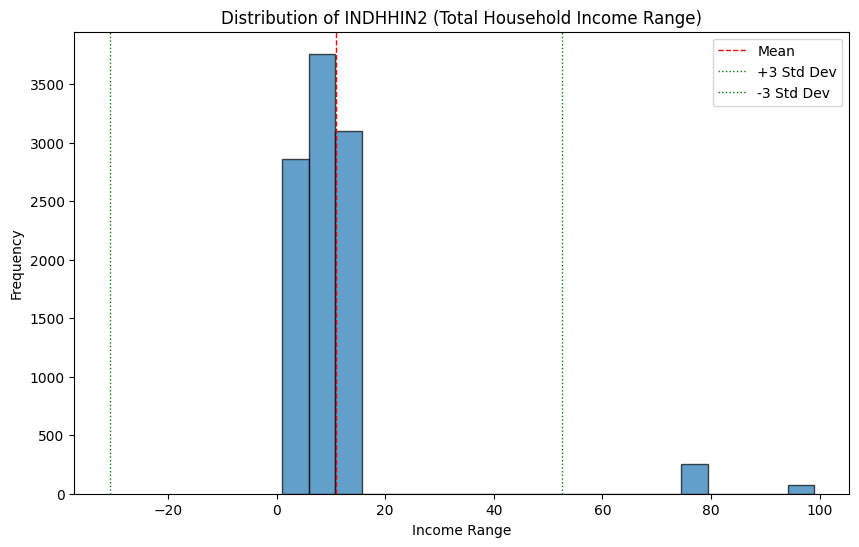

Skewness of INDHHIN2: 4.576362294666127


In [11]:
# Hypothesis 3: Analyze the distribution of the data
plt.figure(figsize=(10, 6))
plt.hist(income_data, bins=20, edgecolor='k', alpha=0.7)
plt.title('Distribution of INDHHIN2 (Total Household Income Range)')
plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.axvline(income_data.mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(income_data.mean() + 3 * income_data.std(), color='g', linestyle='dotted', linewidth=1, label='+3 Std Dev')
plt.axvline(income_data.mean() - 3 * income_data.std(), color='g', linestyle='dotted', linewidth=1, label='-3 Std Dev')
plt.legend()
plt.show()

# Check skewness
skewness = income_data.skew()
print(f"Skewness of INDHHIN2: {skewness}")

### Findings:
* Placeholder values "99.0" accounted for a significant number of anomalies.
* The data is heavily right-skewed, which makes Z-Score assumptions less reliable.
* Removing placeholder values and using a robust anomaly detection method may improve results.